# Sprint11課題 深層学習スクラッチディープニューラルネットワーク

## この課題の目的

- スクラッチを通してニューラルネットワークの発展的内容を理解する

## スクラッチによる実装

NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

前回作成した3層のニューラルネットワークを、クラスを活用することで、任意の構成に拡張しやすいコードに書き換えていきます。その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていきます。

このようなスクラッチを行うことで、今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指します。

### 新たなニューラルネットワーク分類器のクラスを作成する

Sprint9で作成したものとは別に、ニューラルネットワーク分類器のクラスScratchDeepNeuralNetrowkClassifierを作成してください。

### 層などのクラス化

コーディング

クラスにまとめて行くことで、構成を変更しやすい実装にしていきます。

手を加える箇所

- 層の数
- 層の種類（今後は畳み込み層など他のタイプの層が登場する）
- 活性化関数の種類
- 重みやバイアスの初期化方法
- 最適化手法

そのために、全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成します。

実装方法は自由ですが、簡単な例を紹介します。サンプルコード1のように全結合層と活性化関数のインスタンスを作成し、サンプルコード2,3のようにして使用する。それぞれのクラスについてはこのあと解説します。

In [1]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [4]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


## 【問題1】全結合層のクラス化

コーディング

全結合層のクラスの雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。

重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。

なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。

また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself = self.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。

初期化方法と最適化手法のクラスについては後述します。

In [6]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : インスタンス
        初期化方法のインスタンス
    optimizer : インスタンス
        最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer #最適化手法
        
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)

    
    def forward(self, Z1):
        """
        フォワードプロバケーション
        Parameters
        ----------
        Z1 : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
            
        Returns
        ----------
        Z2 : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.Z = Z1.copy()
        #バイアスと重みを結合
        Z2 = np.dot(Z1, self.W) + self.B
        
        return Z2
    
    
    def backward(self, dA):
        """
        バックプロバケーション
        Parameters
        ----------
        dA : 次の形のndarray, shape(batch_size, n_nodes2)
            後ろから流れてきた勾配
            
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        #Zに関する損失の勾配を計算
        self.dB = dA 
        self.dW = np.dot(self.Z.T, dA) 
        dZ = np.dot(dA, self.W.T) 
        
        # 重み、バイアスの更新
        self = self.optimizer.update(self)
        
        return dZ

## 【問題2】初期化方法のクラス化

前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。

これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

In [7]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma #重みパラメータ
        

    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """
        W =  self.sigma * np.random.randn(n_nodes1, n_nodes2) 
    
        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :次の形のndarray, shape (n_nodes2)
            バイアス
        """
        B = np.zeros(n_nodes2)
        
        return B

## 【問題3】最適化手法のクラス化

最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself = self.optimizer.update(self)のように更新できるようにします。こちらも雛形を用意しましたので、必要なコードを書き加えていってください。

これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

In [8]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    alpha : float
        学習率
    """
    def __init__(self, alpha):
        self.alpha = alpha #学習率
        

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : インスタンス
            更新前の層のインスタンス

        Returns
        ----------
        layer : インスタンス
            更新後の層のインスタンス
        """
        #バッチサイズで割る
        layer.W -= self.alpha* layer.dW / layer.dB.shape[0] #(n_nodes1, n_nodes2)
        layer.B -= self.alpha* layer.dB.mean(axis=0) #(n_nodes2)
        
        return layer

## 【問題4】活性化関数のクラス化

活性化関数もクラス化を行なってください。

上記サンプルコード3ではソフトマックス関数のバックプロパゲーションに交差エントロピー誤差の計算も含む実装を想定しています。

In [9]:
class Sigmoid:
    '''
    シグモイド関数のクラス
    Attributes
    --------------
    Z : ndarray
        活性化関数を計算した配列
    '''
    def __init__(self):
        self.Z = None #活性化関数の配列
    

    def forward(self, A):
        '''
        フォワードプロバケーション
        Parameters
        --------------
        A : 次の形のndarray, shape (batch_size, n_nodes1)
            特徴量ベクトルと重みとバイアスを計算したもの
        
        Returns
        ---------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            活性化関数を計算したもの
        '''
        self.Z = 1 / (1 + np.exp(-A)) 
        
        return self.Z
    
    
    def backward(self, dZ):
        '''
        バックプロバケーション
        Parameters
        --------------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            Zに関する損失Lの勾配
        
        Returns
        ---------
        dA : 次の形のndarray, shape (batch_size, n_nodes1)  
           Aに関する損失Lの勾配 
        '''
        dA = dZ * (1 - self.Z) * self.Z
        
        return dA

In [10]:
class Tanh:
    '''
    ハイパポリックタンジェント関数のクラス
    Attributes
    --------------
    Z : ndarray
        活性化関数を計算した配列
    '''
    def __init__(self):
        self.Z = None #活性化関数の配列

    
    def forward(self, A):
        '''
        フォワードプロバケーション
        Parameters
        --------------
        A : 次の形のndarray, shape (batch_size, n_nodes1)
            特徴量ベクトルと重みとバイアスを計算したもの
        
        Returns
        ---------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            活性化関数を計算したもの
        '''
        self.Z =  np.tanh(A)
        
        return  self.Z
    
    
    def backward(self, dZ):
        '''
        バックプロバケーション
        Parameters
        --------------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            Zに関する損失Lの勾配
        
        Returns
        ---------
        dA : 次の形のndarray, shape (batch_size, n_nodes1)  
           Aに関する損失Lの勾配 
        '''
        dA = dZ * (1 - self.Z**2)
        
        return dA

In [11]:
class Softmax:
    '''
    ソフトマックス関数のクラス
    Attributes
    --------------
    Z : ndarray
        活性化関数を計算した配列
    '''
    def __init__(self):
        self.Z = None #活性化関数の配列
    
    
    def forward(self, A):
        '''
        フォワードプロバケーション
        Parameters
        --------------
        A : 次の形のndarray, shape (batch_size, n_output)
            特徴量ベクトルと重みとバイアスを計算したもの
        
        Returns
        ---------
        Z : 次の形のndarray, shape (batch_size, n_output)
            ソフトマックス関数の計算結果
        '''
        #オーバーフロー対策
        c = np.max(A)
        exp_A = np.exp(A - c)
        
        #分母
        sum_exp_A = np.sum(exp_A, axis=1).reshape(-1, 1)

        self.Z = exp_A / sum_exp_A
        
        return self.Z

    
    def backward(self, y):
        '''
        バックプロバケーション
        Parameters
        --------------
        y : 次の形のndarray, shape (batch_size, n_output)
            正解ラベルのベクトル
        Z : 次の形のndarray, shape (batch_size, n_output)
            フォワードプロバケーションの出力
        
        Returns
        ---------
        dA : 次の形のndarray, shape (batch_size, n_nodes1)  
           Aに関する損失Lの勾配 
        '''
        #交差エントロピー誤差の計算
        loss_sum = np.sum(y * np.log(self.Z), axis=1)
        loss = -np.mean(loss_sum)
        
        #勾配の計算
        dA = self.Z - y
        
        return dA, loss

## 【問題5】ReLUクラスの作成

現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装します。

ReLUは以下の数式です。

$$
f(x) = ReLU(x) = 
\begin{cases}
x  & \text{if x}>0,\\
0 & \text{if x} \geqq 0.
\end{cases}
$$

$x$ : ある特徴量。スカラー

実装上はnp.maximumを使い配列に対してまとめて計算が可能です。

[numpy.maximum — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.maximum.html)

一方、バックプロパゲーションのための $x$ に関する $f(x)$ の微分は以下のようになります。

$$
\frac{\partial f(x)}{\partial x} = 
\begin{cases}
1  & \text{if x}>0,\\
0 & \text{if x}\leqq 0.
\end{cases}
$$

数学的には微分可能ではないですが、 $x=0$ のとき $0$ とすることで対応しています。

フォワード時の $x$ の正負により、勾配を逆伝播するかどうかが決まるということになります。

In [12]:
class Relu:
    '''
    ReLU関数のクラス
    Attributes
    --------------
    X : ndarray
        特徴量ベクトルと重みとバイアスを計算した配列
    '''
    def __init__(self):
        self.X = None #特徴量ベクトルと重みとバイアスを計算した配列

    
    def forward(self, A):
        '''
        フォワードプロバケーション
        Parameters
        --------------
        A : 次の形のndarray, shape (batch_size, n_nodes1)
            特徴量ベクトルと重みとバイアスを計算したもの
        
        Returns
        ---------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            活性化関数を計算したもの
        '''
        self.X = A.copy()
        
        #Aが0以下なら0にする
        Z = np.maximum(0, A)
        
        return Z
    
    
    def backward(self, dZ):
        '''
        バックプロバケーション
        Parameters
        --------------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            Zに関する損失Lの勾配
        
        Returns
        ---------
        dA : 次の形のndarray, shape (batch_size, n_nodes1)  
           Aに関する損失Lの勾配 
        '''
        #forwardで0以下の部分を0にする
        dA = np.where(self.X > 0, dZ, 0)

        return dA

## 【問題6】重みの初期値

ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、一般的に良い初期値の取り方が知られています。

シグモイド関数やハイパボリックタンジェント関数のときはXavierの初期値（またはGlorotの初期値）、ReLUのときはHeの初期値が使われます。

XavierInitializerクラスと、HeInitializerクラスを作成します。

それぞれの初期化方法における $\sigma$ は次の式で求められます。

「Xavierの初期値」

$$
\sigma = \frac{1}{\sqrt{n}}
$$

$n$ : 前の層のノード数

（論文）

[Glorot, X., & Bengio, Y. (n.d.). Understanding the difficulty of training deep feedforward neural networks.](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

In [13]:
class XavierInitializer:
    """
    Xavierの初期値のクラス
    """
    def __init__(self):
        pass
        

    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """
        W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1) #(n_nodes1, n_nodes2)
    
        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes2, )
            バイアス
        """
        B = np.zeros(n_nodes2) #(n_nodes2)
        
        return B

「Heの初期値」

$$
\sigma = \sqrt{\frac{2}{n}}
$$

$n$ : 前の層のノード数

（論文）

[He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification.](https://arxiv.org/pdf/1502.01852.pdf)

In [14]:
class HeInitializer:
    """
    Heの初期値のクラス
    """
    def __init__(self):
        pass
        

    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """
        W = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)
    
        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes2, )
            バイアス
        """
        B = np.zeros(n_nodes2) 
        
        return B

## 【問題7】最適化手法

コーディング

学習率は学習の良し悪しにとって重要なハイパーパラメータであり、これを学習過程で変化させていく方法が現在では一般的です。様々な手法が提案されていますが、今回はその中でも基本的な、AdaGradを実装します。

まず、これまで使ってきたSGDを確認します。

$$
W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i}) 
$$

$$
B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})
$$

$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）

$\frac{\partial L}{\partial W_i}$ : $W_i$ に関する損失 $L$ の勾配

$\frac{\partial L}{\partial B_i}$ : $B_i$ に関する損失 $L$ の勾配

$E()$ : ミニバッチ方向にベクトルの平均を計算

続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。

更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和 $H$ を保存しておき、その分だけ学習率を小さくします。

学習率は重み一つひとつに対して異なることになります。

$$
H_i^{\prime}  = H_i+E(\frac{\partial L}{\partial W_i})\times E(\frac{\partial L}{\partial W_i})
$$

$$
W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) 
$$

$H_i$  : $i$層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）

$H_i^{\prime}$ : 更新した $H_i$

AdaGradクラスを作成し、上記の数式にもとづいて実装してください。

（論文）

[Duchi JDUCHI, J., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization * Elad Hazan. Journal of Machine Learning Research (Vol. 12).](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)

In [15]:
class AdaGrad:
    """
    AdaGradの最適化のクラス
    Parameters
    ----------
    alpha : 学習率
    
    Attributes
    -------------
    H_W : ndarray
        前のイテレーションまでの重みの勾配の二乗和
    H_B : ndarray
        前のイテレーションまでのバイアスの勾配の二乗和
    """
    def __init__(self, alpha):
        #ハイパーパラメータ
        self.alpha = alpha #学習率
        
        #インスタンス変数
        self.H_W= None #重みの勾配の二乗和の配列
        self.H_B = None #バイアスの勾配の二乗和の配列
        

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : インスタンス
            更新前の層のインスタンス

        Returns
        ----------
        layer : インスタンス
            更新後の層のインスタンス
        """
        #self.Hの初期化
        if self.H_W is None:
            self.H_W = np.zeros(layer.W.shape)
        if self.H_B is None:
            self.H_B = np.zeros(layer.B.shape)
        
        #更新    
        self.H_W += (layer.dW / layer.dB.shape[0]) ** 2 #重みの勾配の二乗和
        self.H_B += (layer.dB.mean(axis=0)) ** 2 #バイアスの二乗和
        layer.W -= self.alpha / np.sqrt(self.H_W + 1e-7) * layer.dW / layer.dB.shape[0] #重み
        layer.B -= self.alpha / np.sqrt(self.H_B + 1e-7) * layer.dB.mean(axis=0) #バイアス 
        
        return layer

### クラスの結合

In [16]:
import numpy as np

class ScratchDeepNeuralNetrowkClassifier():
    """
    ニューラルネットワーク分類器

    Parameters
    --------------
    epoc : int
        エポック数
    activaiton : {'sigmoid', 'tanh', 'relu'} default 'relu'
        活性化関数の種類
    solver :  {'sgd', 'adagrad'}, default 'adam'
        最適化手法の種類
    alpha : float
        学習率
    batch_size : int
        バッチサイズ
    initial : {'simple', 'xavier', 'he'} default 'he'
        重みの初期化方法
    sigma : float
        重みパラメータ(ガウス分布の標準偏差)
    n_nodes1 : int
        1層目の数
    n_nodes2 : int
        2層目の数
    n_output : int
        出力層の数
    verbose : bool
        学習過程の出力の有無
        
    Attributes
    -------------
    FC1 :  インスタンス
        結合層のインスタンス
    FC2 :   インスタンス
        結合層のインスタンス
    FC3 :   インスタンス
        結合層のインスタンス
    activation1 : インスタンス
        活性化関数のインスタンス
    activation2 : インスタンス
        活性化関数のインスタンス
    activation3 : インスタンス
        活性化関数のインスタンス
    loss_list : list
        学習用データのエポックごとの損失を記録するリスト
     mini_loss_list : list
        学習用データのイテレーションごとの損失を記録するリスト   
    val_loss_list : list
        検証用データのエポックごとの損失を記録するリスト
    mini_val_loss_list : list
        検証用データのイテレーションごとの損失を記録するリスト        
    """
    def __init__(self, epoc=20, activation='relu', solver='adagrad', alpha=0.005,
                             batch_size=10, initial='he', sigma=0.01, n_nodes1=400, 
                             n_nodes2=200, verbose=True):
        #ハイパーパラメータ 
        self.epoc            = epoc              #エポック数
        self.activation   = activation     #活性化関数
        self.solver          = solver            #最適化の手法
        self.alpha           = alpha             #学習率
        self.batch_size = batch_size   #バッチサイズ
        self.initial           = initial             #重みの初期化方法
        self.sigma          = sigma            #重みパラメータ
        self.n_nodes1   = n_nodes1    #1層目のノード数
        self.n_nodes2   = n_nodes2    #2層目のノード数
        self.verbose      = verbose        #学習過程の出力(True : 有, False : 無)
        
        #インスタンス変数
        self.FC1                         = None #結合層のインスタンス
        self.FC2                         = None #結合層のインスタンス
        self.FC3                          = None #結合層のインスタンス
        self.activation1             = None #活性化関数のインスタンス
        self.activation2             = None #活性化関数のインスタンス
        self.activation3             = None #活性化関数のインスタンス
        self.loss_list                  = None #学習用データの損失を記録する配列
        self.mini_loss_list         = None #学習用データのイテレーションごとの損失を記録する配列        
        self.val_loss_list           = None #検証用データの損失を記録する配列
        self.mini_val_loss_list  = None #検証用データのイテレーションごとの損失を記録する配列
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        #1次元なら2次元にする
        if X.ndim == 1:
            X = X[:, np.newaxis]
        if y.ndim == 1:
            y = y[:, np.newaxis]
            
        #one_hotエンコーディング
        n_output = np.unique(y).shape[0]
        y_onehot = self._one_hot(y, n_output)
        
        #ミニバッチを取得するクラスをインスタンス化
        train_mini_batch = GetMiniBatch(X, y_onehot, self.batch_size)
        
        #valがあるとき
        if X_val is not None and y_val is not None:
            
            #1次元なら2次元にする
            if X.ndim == 1:
                X_val = X_val[:, np.newaxis]
            if y_val.ndim == 1:
                y_val = y_val[:, np.newaxis]
            
            #one-hotエンコーディング
            y_val_onehot = self._one_hot(y_val, n_output) 
            
            #インスタンス化
            test_mini_batch = GetMiniBatch(X_val, y_val_onehot)
        
        
        #活性化関数の選択
        if self.activation == 'sigmoid':
            activate1 = Sigmoid()
            activate2 = Sigmoid()
        elif self.activation == 'tanh':
            activate1 = Tanh()
            activate2 = Tanh()
        elif self.activation == 'relu':
            activate1 = Relu()
            activate2 = Relu()
        
        #最適化手法の選択
        if self.solver == 'sgd':
            optimizer1 = SGD(self.alpha)
            optimizer2 = SGD(self.alpha)
            optimizer3 = SGD(self.alpha) 
        elif self.solver == 'adagrad':
            optimizer1 = AdaGrad(self.alpha)
            optimizer2 = AdaGrad(self.alpha)
            optimizer3 = AdaGrad(self.alpha)
            
        #重みの初期化方法の選択
        if self.initial == 'simple':
            initializer1 = SimpleInitializer(self.sigma)
            initializer2 = SimpleInitializer(self.sigma)
            initializer3 = SimpleInitializer(self.sigma)
        elif self.initial == 'xavier':
            initializer1 = XavierInitializer()
            initializer2 = XavierInitializer()
            initializer3 = XavierInitializer()
        elif self.initial == 'he':
            initializer1 = HeInitializer()
            initializer2 = HeInitializer()
            initializer3 = HeInitializer()
        
        #結合層および活性化関数クラスのインスタンス化
        self.FC1 = FC(X.shape[1], self.n_nodes1, initializer1, optimizer1) #第1層
        self.activation1 = activate1
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer2, optimizer2) #第2層
        self.activation2 = activate2
        self.FC3 = FC(self.n_nodes2, y_onehot.shape[1], initializer3, optimizer3) #第3層
        self.activation3 = Softmax()

        #損失を記録するリスト(エポックごと)
        self.loss_list = []       #学習用
        self.val_loss_list= [] #検証用
        
        #エポック数だけ繰り返す
        for i in range(self.epoc):
            
            #損失を記録するリスト(イテレーション)
            self.mini_loss_list = []
            
            #イテレーション数実行
            for mini_X_train, mini_y_train in train_mini_batch:
                
                #フォワードプロバケーション
                A1 = self.FC1.forward(mini_X_train) #1層目
                Z1 = self.activation1.forward(A1)      #1層目
                A2 = self.FC2.forward(Z1)                   #2層目
                Z2 = self.activation2.forward(A2)      #2層目
                A3 = self.FC3.forward(Z2)                  #3層目
                Z3 = self.activation3.forward(A3)     #3層目

                #バックプロバケーション
                dA3, mini_loss = self.activation3.backward(mini_y_train) #3層目
                dZ2 = self.FC3.backward(dA3)              #3層目
                dA2 = self.activation2.backward(dZ2) #2層目
                dZ1 = self.FC2.backward(dA2)              #2層目
                dA1 = self.activation1.backward(dZ1) #1層目
                dZ0 = self.FC1.backward(dA1)              #1層目
                
                #イテレーションごとの損失をリストに格納
                self.mini_loss_list.append(mini_loss)
                
            #1エポックの損失の平均をリストに格納
            loss = np.mean(self.mini_loss_list)
            self.loss_list.append(loss)

            #valがあるときもイテレーション数実行
            if X_val is not None and y_val is not None:
                
                #損失を記録するリスト(イテレーション)
                self.mini_val_loss_list = []
                for mini_X_val, mini_y_val in test_mini_batch:

                    #確率を予測
                    A1 = self.FC1.forward(mini_X_val)
                    Z1 = self.activation1.forward(A1)
                    A2 = self.FC2.forward(Z1)
                    Z2 = self.activation2.forward(A2)
                    A3 = self.FC3.forward(Z2)
                    Z3 = self.activation3.forward(A3)
                    
                    #損失を計算
                    dA3, mini_val_loss = self.activation3.backward(mini_y_val) 
                    
                    #イテレーションごとの損失をリストに格納
                    self.mini_val_loss_list.append(mini_val_loss)

                #1エポックの損失の平均をリストに格納
                val_loss = np.mean(self.mini_val_loss_list)
                self.val_loss_list.append(val_loss) 

                
            #学習過程を出力する場合
            if self.verbose == True:
                print('学習用データの学習過程' + str(i + 1) + 'epoc目 : ' + str(self.loss_list[i]))

                #検証用データあり
                if X_val is not None or y_val is not None:
                    print('検証用データの学習過程' + str(i + 1) + 'epoc目 : ' + str(self.val_loss_list[i]))
                    
                
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
        次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        #推定
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        y_pred = self.activation3.forward(A3)
        
        return np.argmax(y_pred, axis=1)
            

    def _one_hot(self, y, n_output):
        '''
        one-hotエンコーディングを行う関数
       
       Parameters
        ---------------
        y : 次の形のndarray, shape (n_features, 1)
            正解ラベルのベクトル
        n_output : int
            正解ラベルのユニーク値
            
        Returns
        ----------
        one_hot.T : 次の形のndarray, shape (n_features, n_output)
        '''
        #0配列を用意
        one_hot = np.zeros((n_output, y.shape[0]))
        
        #0配列の該当する位置に1を挿入
        for idx, val in enumerate(y.astype(int)):
            one_hot[val, idx] = 1

        return one_hot.T

In [17]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

### 検証1
- 活性化関数 : シグモイド
- 最適化手法 : AdaGrad
- 重みの初期値 : Xavier

In [18]:
#予測
sdn1 = ScratchDeepNeuralNetrowkClassifier(activation='sigmoid', solver='adagrad', initial='xavier')

sdn1.fit(X_train, y_train, X_val, y_val)

学習用データの学習過程1epoc目 : 0.4723707512173176
検証用データの学習過程1epoc目 : 0.32531447257689583
学習用データの学習過程2epoc目 : 0.2903943552047994
検証用データの学習過程2epoc目 : 0.27990061217551654
学習用データの学習過程3epoc目 : 0.25882342808875525
検証用データの学習過程3epoc目 : 0.2573984704847602
学習用データの学習過程4epoc目 : 0.24003432452248868
検証用データの学習過程4epoc目 : 0.24235803483863422
学習用データの学習過程5epoc目 : 0.22639953048187886
検証用データの学習過程5epoc目 : 0.23099581440789943
学習用データの学習過程6epoc目 : 0.21560892246114552
検証用データの学習過程6epoc目 : 0.22184141839970248
学習用データの学習過程7epoc目 : 0.2066528209917836
検証用データの学習過程7epoc目 : 0.21417442337725584
学習用データの学習過程8epoc目 : 0.19899263314175641
検証用データの学習過程8epoc目 : 0.20758505891353493
学習用データの学習過程9epoc目 : 0.19230157513253568
検証用データの学習過程9epoc目 : 0.20181489359479987
学習用データの学習過程10epoc目 : 0.18636350624347642
検証用データの学習過程10epoc目 : 0.1966887329459774
学習用データの学習過程11epoc目 : 0.1810269048859391
検証用データの学習過程11epoc目 : 0.19208161680887934
学習用データの学習過程12epoc目 : 0.17618116312110332
検証用データの学習過程12epoc目 : 0.1879010922885056
学習用データの学習過程13epoc目 : 0.1717430885389545
検

In [19]:
y_pred1 = sdn1.predict(X_test)

In [20]:
def cost_curve(loss, val_loss):
    plt.plot(loss)
    plt.plot(val_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.title('Cost curve')
    plt.show()

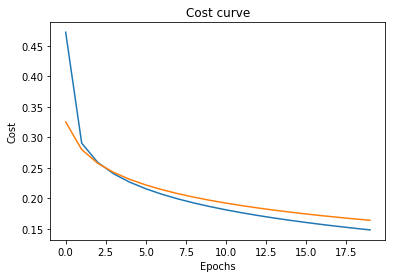

In [21]:
cost_curve(sdn1.loss_list, sdn1.val_loss_list)

In [22]:
def evalution(y_test, y_pred):
    '''
     分類問題の指標値を出力する関数
 
     Paraeters
     -------------
    y_test : 次の形のndarray, shape (n_samples, )
        正解値
    y_pred : 次の形のndarray, shape (n_samples, )
        予測したラベル
    '''
    #accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print('accuracy :', accuracy)

    #precision
    precision = precision_score(y_test, y_pred, average='macro')
    print('precision :', precision)

    #recall
    recall = recall_score(y_test, y_pred, average='macro')
    print('recall :', recall)

    #f1
    f1 = f1_score(y_test, y_pred, average='macro')
    print('f1 :', f1)

In [23]:
evalution(y_test, y_pred1)

accuracy : 0.9534
precision : 0.9529922700454169
recall : 0.9528226949738405
f1 : 0.952843310418455


### 検証2
- 活性化関数 : シグモイド
- 最適化手法 : AdaGrad
- 重みの初期値 : He

In [24]:
#予測
sdn2 = ScratchDeepNeuralNetrowkClassifier(activation='sigmoid', solver='adagrad', initial='he')

sdn2.fit(X_train, y_train, X_val, y_val)

学習用データの学習過程1epoc目 : 0.44119989454303027
検証用データの学習過程1epoc目 : 0.3191849236544275
学習用データの学習過程2epoc目 : 0.2872947113848493
検証用データの学習過程2epoc目 : 0.2787669251486233
学習用データの学習過程3epoc目 : 0.25822150887487866
検証用データの学習過程3epoc目 : 0.2579327394785994
学習用データの学習過程4epoc目 : 0.2404206781958055
検証用データの学習過程4epoc目 : 0.24369297603520929
学習用データの学習過程5epoc目 : 0.22729098703481018
検証用データの学習過程5epoc目 : 0.23276907802183455
学習用データの学習過程6epoc目 : 0.21678196553848542
検証用データの学習過程6epoc目 : 0.22386590102214293
学習用データの学習過程7epoc目 : 0.20798586889866555
検証用データの学習過程7epoc目 : 0.21634244039677242
学習用データの学習過程8epoc目 : 0.20041357569808674
検証用データの学習過程8epoc目 : 0.20983092404798356
学習用データの学習過程9epoc目 : 0.1937653610005469
検証用データの学習過程9epoc目 : 0.20409716900401226
学習用データの学習過程10epoc目 : 0.18784114911860192
検証用データの学習過程10epoc目 : 0.19898072837147776
学習用データの学習過程11epoc目 : 0.1824995094052528
検証用データの学習過程11epoc目 : 0.19436591511407408
学習用データの学習過程12epoc目 : 0.17763639168511516
検証用データの学習過程12epoc目 : 0.19016624461970458
学習用データの学習過程13epoc目 : 0.17317295274389924


In [25]:
y_pred2 = sdn2.predict(X_test)

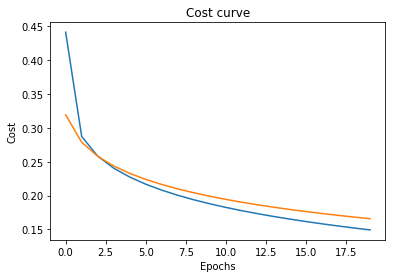

In [26]:
cost_curve(sdn2.loss_list, sdn2.val_loss_list)

In [27]:
evalution(y_test, y_pred2)

accuracy : 0.9525
precision : 0.9521294055799304
recall : 0.9518870192735172
f1 : 0.9519429961615128


### 検証3
- 活性化関数 : Sigmoid
- 最適化手法 : AdaGrad
- 重みの初期値 : Simple(ガウス分布)

In [28]:
#予測
sdn3 = ScratchDeepNeuralNetrowkClassifier(activation='sigmoid', solver='adagrad', initial='simple')

sdn3.fit(X_train, y_train, X_val, y_val)

学習用データの学習過程1epoc目 : 1.1269762766492961
検証用データの学習過程1epoc目 : 0.5483257745269349
学習用データの学習過程2epoc目 : 0.4173874251305708
検証用データの学習過程2epoc目 : 0.3587749246224191
学習用データの学習過程3epoc目 : 0.3244596028853096
検証用データの学習過程3epoc目 : 0.3108860260897431
学習用データの学習過程4epoc目 : 0.289620203696631
検証用データの学習過程4epoc目 : 0.28501982065111864
学習用データの学習過程5epoc目 : 0.2681909174948082
検証用データの学習過程5epoc目 : 0.26734894659026837
学習用データの学習過程6epoc目 : 0.2524787772870683
検証用データの学習過程6epoc目 : 0.2538276387686304
学習用データの学習過程7epoc目 : 0.23990501652785207
検証用データの学習過程7epoc目 : 0.24281955634185035
学習用データの学習過程8epoc目 : 0.22934328434060697
検証用データの学習過程8epoc目 : 0.23352634143912734
学習用データの学習過程9epoc目 : 0.22021022724792735
検証用データの学習過程9epoc目 : 0.22549776909061606
学習用データの学習過程10epoc目 : 0.21216316210067795
検証用データの学習過程10epoc目 : 0.21845029039327143
学習用データの学習過程11epoc目 : 0.20498024990786098
検証用データの学習過程11epoc目 : 0.21219003056726451
学習用データの学習過程12epoc目 : 0.19850679630730222
検証用データの学習過程12epoc目 : 0.2065765052049298
学習用データの学習過程13epoc目 : 0.19262852110228365
検証用デー

In [29]:
y_pred3 = sdn3.predict(X_test)

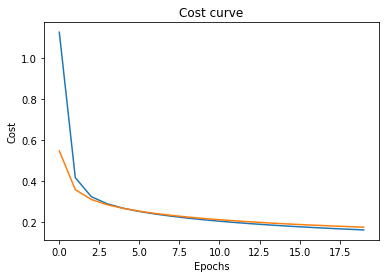

In [30]:
cost_curve(sdn3.loss_list, sdn3.val_loss_list)

In [31]:
evalution(y_test, y_pred3)

accuracy : 0.9501
precision : 0.9496432355407276
recall : 0.9495232988921
f1 : 0.9495230771946988


### 検証4
- 活性化関数 : ReLu
- 最適化手法 : SGD
- 重みの初期値 : He

In [32]:
#予測
sdn4 = ScratchDeepNeuralNetrowkClassifier(activation='relu', solver='sgd', initial='he')

sdn4.fit(X_train, y_train, X_val, y_val)

学習用データの学習過程1epoc目 : 0.50193422303541
検証用データの学習過程1epoc目 : 0.28214929690646046
学習用データの学習過程2epoc目 : 0.2429906414620343
検証用データの学習過程2epoc目 : 0.21754613877795406
学習用データの学習過程3epoc目 : 0.19058098200139087
検証用データの学習過程3epoc目 : 0.18268007473724363
学習用データの学習過程4epoc目 : 0.15780419439668622
検証用データの学習過程4epoc目 : 0.15926503258964878
学習用データの学習過程5epoc目 : 0.13452435554316403
検証用データの学習過程5epoc目 : 0.14222899786447105
学習用データの学習過程6epoc目 : 0.1168049647816629
検証用データの学習過程6epoc目 : 0.12954565787934408
学習用データの学習過程7epoc目 : 0.10273074434500974
検証用データの学習過程7epoc目 : 0.11950629783020154
学習用データの学習過程8epoc目 : 0.09108595584694636
検証用データの学習過程8epoc目 : 0.11170840456856841
学習用データの学習過程9epoc目 : 0.081274646158493
検証用データの学習過程9epoc目 : 0.1053912201358356
学習用データの学習過程10epoc目 : 0.07287849451285869
検証用データの学習過程10epoc目 : 0.10021926034074675
学習用データの学習過程11epoc目 : 0.06561541100424034
検証用データの学習過程11epoc目 : 0.09586317745541213
学習用データの学習過程12epoc目 : 0.05924514429826221
検証用データの学習過程12epoc目 : 0.09231262291136673
学習用データの学習過程13epoc目 : 0.053634788602095425


In [33]:
y_pred4 = sdn4.predict(X_test)

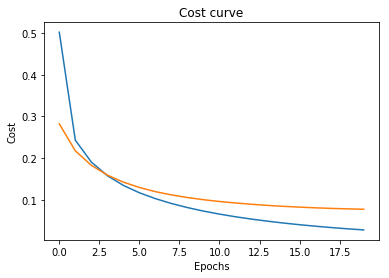

In [34]:
cost_curve(sdn4.loss_list, sdn4.val_loss_list)

In [35]:
evalution(y_test, y_pred4)

accuracy : 0.9773
precision : 0.977369363999275
recall : 0.9769586654861234
f1 : 0.9771244632681707


### 検証5
- 活性化関数 : ReLu
- 最適化手法 : AdaGrad
- 重みの初期値 : He

In [36]:
#予測
sdn5 = ScratchDeepNeuralNetrowkClassifier(activation='relu', solver='adagrad', initial='he')

sdn5.fit(X_train, y_train, X_val, y_val)

学習用データの学習過程1epoc目 : 0.21144251933925615
検証用データの学習過程1epoc目 : 0.14112638948349646
学習用データの学習過程2epoc目 : 0.10992773659049253
検証用データの学習過程2epoc目 : 0.11396218003164066
学習用データの学習過程3epoc目 : 0.08432012656353545
検証用データの学習過程3epoc目 : 0.10050871603056744
学習用データの学習過程4epoc目 : 0.06927045048849036
検証用データの学習過程4epoc目 : 0.09228633251899555
学習用データの学習過程5epoc目 : 0.058738611004086325
検証用データの学習過程5epoc目 : 0.08664395913192986
学習用データの学習過程6epoc目 : 0.05083883618574647
検証用データの学習過程6epoc目 : 0.0824939239979371
学習用データの学習過程7epoc目 : 0.044638920970855304
検証用データの学習過程7epoc目 : 0.07944809943357332
学習用データの学習過程8epoc目 : 0.03962475057225752
検証用データの学習過程8epoc目 : 0.07710410906887409
学習用データの学習過程9epoc目 : 0.03546433173099914
検証用データの学習過程9epoc目 : 0.07526930513552738
学習用データの学習過程10epoc目 : 0.03194868132883898
検証用データの学習過程10epoc目 : 0.07380236874738429
学習用データの学習過程11epoc目 : 0.028933474116637492
検証用データの学習過程11epoc目 : 0.07259873998930921
学習用データの学習過程12epoc目 : 0.02633219225412071
検証用データの学習過程12epoc目 : 0.07163689612796233
学習用データの学習過程13epoc目 : 0.024066516

In [37]:
y_pred5 = sdn5.predict(X_test)

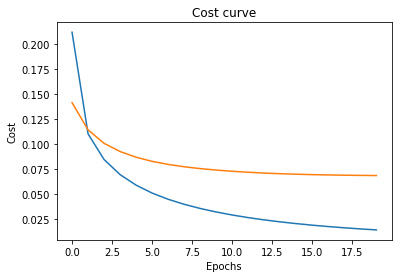

In [38]:
cost_curve(sdn5.loss_list, sdn5.val_loss_list)

In [39]:
evalution(y_test, y_pred5)

accuracy : 0.9811
precision : 0.9810572481919451
recall : 0.9809063285036845
f1 : 0.9809675669219227


### 検証6
- 活性化関数 : Tanh
- 最適化手法 : AdaGrad
- 重みの初期値 : Xavier

In [40]:
#予測
sdn6 = ScratchDeepNeuralNetrowkClassifier(activation='tanh', solver='adagrad', initial='xavier')

sdn6.fit(X_train, y_train, X_val, y_val)

学習用データの学習過程1epoc目 : 0.28102099402185254
検証用データの学習過程1epoc目 : 0.2192397295802787
学習用データの学習過程2epoc目 : 0.1887854936206203
検証用データの学習過程2epoc目 : 0.18495782531194913
学習用データの学習過程3epoc目 : 0.15995350882474804
検証用データの学習過程3epoc目 : 0.16604669935381355
学習用データの学習過程4epoc目 : 0.14186198350295542
検証用データの学習過程4epoc目 : 0.15323563550153638
学習用データの学習過程5epoc目 : 0.1287132335117439
検証用データの学習過程5epoc目 : 0.14367532896164784
学習用データの学習過程6epoc目 : 0.11842976354545443
検証用データの学習過程6epoc目 : 0.13614635100504985
学習用データの学習過程7epoc目 : 0.11002510031287799
検証用データの学習過程7epoc目 : 0.130008305975003
学習用データの学習過程8epoc目 : 0.10294956652085675
検証用データの学習過程8epoc目 : 0.12487913274459113
学習用データの学習過程9epoc目 : 0.09686286903786498
検証用データの学習過程9epoc目 : 0.12051124474856671
学習用データの学習過程10epoc目 : 0.09153893290935895
検証用データの学習過程10epoc目 : 0.11673482452336875
学習用データの学習過程11epoc目 : 0.08682005340806993
検証用データの学習過程11epoc目 : 0.11342873504353318
学習用データの学習過程12epoc目 : 0.0825920976123461
検証用データの学習過程12epoc目 : 0.11050404899627499
学習用データの学習過程13epoc目 : 0.07876996249452711

In [41]:
y_pred6 = sdn6.predict(X_test)

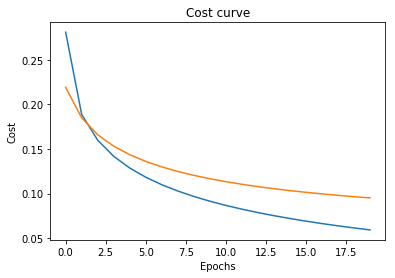

In [42]:
cost_curve(sdn6.loss_list, sdn6.val_loss_list)

In [43]:
evalution(y_test, y_pred6)

accuracy : 0.9722
precision : 0.9721911565571713
recall : 0.9719121938924846
f1 : 0.9720208862606391


重みの初期化方法は、シグモイド関数やハイパボリックタンジェント関数のときはXavier、ReLUのときはHeの初期値が推奨されている。シグモイド関数、ハイパポリックタンジェント関数でXavierの初期値を用いた場合、活性化関数後の出力データは、ガウス分布と比較して広がりをもった釣鐘型の形とため、より効率的に学習できる。一方、ReLU関数では負の領域が0となるため、より分布の広がりを持たせるHeの初期値を用いることで、効率よく学習できる。

シグモイド関数で重みの初期化方法をXavier(検証1), He(検証2), ガウス分布(検証3)の3種類試し、一番精度が良かったのは推奨されているXavierを用いた場合であった。

次に、活性化関数がReLU、重みの初期化方法をHeとして、最適化方法をSGD(検証4)、AdaGrad(検証5)の2種類を試し、精度がよかったのはAdaGradを用いた場合であった。AdaGradは学習を進めるにつれて学習率を小さくするため、SGDより効率的に誤差を最小にすることができる。

検証1、5、6では最適化手法をAdaGradで、活性化関数と重みの初期化方法シグモイド、ハイパポリックタンジェント関数であればXavier、ReLUなら Heと、推奨されている組み合わせを試し、一番精度が良かったのが活性化関数にReLU関数を用いた組み合わせ(検証5)であった。